# Model Training

Detection Model: Yolo v4 by AlexeyAB / Tianxiaomo / WongKinYiu, 1 class (Sock)

https://github.com/AlexeyAB/darknet ->Currently we use this (reference: https://colab.research.google.com/drive/12QusaaRj_lUwCGDvQNfICpa7kA7_a2dE#scrollTo=G9Fv0wjCMPYY )

https://github.com/Tianxiaomo/pytorch-YOLOv4

https://github.com/roboflow-ai/pytorch-YOLOv4


Classification Model: EfficientNet by lukemelas, >= 10 classes

https://github.com/lukemelas/EfficientNet-PyTorch

(with a great help of https://keep-steady.tistory.com/35  )

In [ ]:
from google.colab import drive
drive.mount('/gdrive') 

ROOT_DIR = "/gdrive/MyDrive/CS470_Socks_Sorting/"

Mounted at /gdrive


In [ ]:
%cd $ROOT_DIR

/gdrive/MyDrive/CS470_Socks_Sorting


In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
  return list(uploaded.keys())

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec  8 07:12:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Models

In [ ]:
#!git clone https://github.com/AlexeyAB/darknet
#!git clone https://github.com/lukemelas/EfficientNet-PyTorch

## a) Darknet

In [ ]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/gdrive/MyDrive/CS470_Socks_Sorting/darknet


In [ ]:
!make

chmod +x *.sh
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image.c -o obj/image.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/activations.c -o obj/activations.o
./src/activations.c: In function ‘activate’:
./src/activations.c:79:5: warning: enumeration value ‘RELU6’ not handled in switch [-Wswitch]
     switch(a){
     ^~~~~~
./src/activations.c:79:5: warning: enumeration value ‘SWISH’ not handled in switch [-Wswitch]
./src/activations.c:79:5: w

## b) Efficientnet-Pytorch

In [ ]:
%cd $ROOT_DIR/EfficientNet-PyTorch
!pip install -e .


/gdrive/MyDrive/CS470_Socks_Sorting/EfficientNet-PyTorch
efficientnet_pytorch/           hubconf.py  setup.py            tests/
efficientnet_pytorch.egg-info/  LICENSE     sotabench.py        tf_to_pytorch/
examples/                       logs/       sotabench_setup.sh
Obtaining file:///gdrive/My%20Drive/CS470_Socks_Sorting/EfficientNet-PyTorch
  Running setup.py develop for efficientnet-pytorch


## Setup

In [ ]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import requests
from glob import glob

#!pip install torchvision==0.5.0
import torchvision
from torchvision import transforms as T
from torchvision import datasets
!pip install tensorboardX
from tensorboardX import SummaryWriter



     |████████████████████████████████| 317kB 5.9MB/s 


# 2. Training Yolo on OID



### Yolov4, 1class (AlexeyAB)

In [ ]:
%cd $ROOT_DIR
%cd darknet

%cp ../OID/Sock/images/val/*.jpg data/test/
%cp ../OID/Sock/labels/val/*.txt data/test/

%cp ../OID/Sock/images/train/*.jpg data/obj/
%cp ../OID/Sock/labels/train/*.txt data/obj/

/gdrive/MyDrive/CS470_Socks_Sorting
/gdrive/MyDrive/CS470_Socks_Sorting/darknet


In [ ]:
!python generate_train.py
!python generate_test.py

In [ ]:
%cd $ROOT_DIR
%cd darknet

#!./darknet detector -h
#!./darknet detector train data/obj.data cfg/yolov4-1cls.cfg weights/yolov4.conv.137 -dont_show -map
!./darknet detector train data/obj.data cfg/yolov4-tiny-1cls.cfg weights/yolov4-tiny.conv.29 -dont_show -map

# 3. Training Yolo on Custom Dataset

In [ ]:
from tqdm import tqdm
import io

labelbox_path = ROOT_DIR + "labelbox_json/export-2020-12-06T02_18_12.389Z.json"
save_dir = ROOT_DIR + "Sock+Clothing/"
if not os.path.isdir(save_dir):
  os.mkdir(save_dir)
  os.mkdir(save_dir+"images/")
  os.mkdir(save_dir+"labels/")
train_val_test_ratio = [.7, .2, .1]
download_images = True


np.random.seed(0)
with open(labelbox_path, 'r') as label:
  labelbox_data = json.load(label)
for _, row in tqdm(enumerate(labelbox_data)):
  img_id = row["ID"]
  img_uri = row["Labeled Data"]
  partition = np.random.choice(['train', 'val', 'test'], p=train_val_test_ratio)
  images_dir = save_dir + f"images/{partition}/"
  labels_dir = save_dir + f"labels/{partition}/"
  try:
    os.mkdir(images_dir)
    os.mkdir(labels_dir)
  except:
    pass

  # download img
  r = requests.get(img_uri)
  assert r.status_code == requests.codes.ok, 'Status code error: {}.'.format(r.status_code)
  img = Image.open(io.BytesIO(r.content))
  width, height = img.size

  # convert labelbox json bbox into yolo bbox
  labels = row["Label"].get("objects", [])  # list of labels
  data = ""
  for label in labels:
    if "bbox" not in label:
        continue
    bbox = label["bbox"]
    y, x, h, w = bbox["top"], bbox["left"], bbox["height"], bbox["width"]
    x1, y1, x2, y2 = x, y, x+w, y+h  # top left & bottom right
    xm, ym = (x1+x2)/2., (y1+y2)/2.  # center x & center y
    xm, ym, w, h = xm/width, ym/height, w/width, h/height  # normalize
    data += f"0 {xm:.6f} {ym:.6f} {w:.6f} {h:.6f}\n"
  
  # save img
  if download_images:
    img_path = images_dir + img_id + ".jpg"
    img.save(img_path)
  # save label
  label_path = labels_dir + img_id + ".txt"
  with open(label_path, "w") as f:
    f.write(data)

167it [01:13,  2.26it/s]


In [ ]:
%cd $ROOT_DIR
%cd darknet

%cp ../Sock+Clothing/images/val/*.jpg data/test/
%cp ../Sock+Clothing/labels/val/*.txt data/test/

%cp ../Sock+Clothing/images/train/*.jpg data/obj/
%cp ../Sock+Clothing/labels/train/*.txt data/obj/

/gdrive/MyDrive/CS470_Socks_Sorting
/gdrive/MyDrive/CS470_Socks_Sorting/darknet


In [ ]:
!python generate_train.py
!python generate_test.py

In [ ]:
%cd $ROOT_DIR
%cd darknet

#!./darknet detector train data/obj.data cfg/yolov4-1cls.cfg weights/yolov4.conv.137 -dont_show -map
!./darknet detector train data/Sock.data cfg/yolov4-tiny-custom.cfg backup/yolov4-tiny-1cls_best.weights -dont_show -map

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 28.14 MB 
 CUDA allocate done! 
Loaded: 0.727031 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 30 Avg (IOU: 0.740350, GIOU: 0.738612), Class: 0.999571, Obj: 0.582295, No Obj: 0.006120, .5R: 0.857143, .75R: 0.571429, count: 7, class_loss = 0.887882, iou_loss = 0.384311, total_loss = 1.272193 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 37 Avg (IOU: 0.815064, GIOU: 0.809069), Class: 0.997801, Obj: 0.678188, No Obj: 0.001412, .5R: 1.000000, .75R: 0.833333, count: 6, class_loss = 0.559606, iou_loss = 4.450437, total_loss = 5.010043 
 total_bbox = 791428, rewritten_bbox = 1.349333 % 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 30 Avg (IOU: 0.850992, GIOU: 0.847488), Class: 0.999013, Obj: 0.782640, No Obj: 0.008115, .5R: 1.000000, .75R: 0.833333, count: 6, class_loss = 0.242558, io

## 4. Detection Result (Examples)

In [ ]:
%cd ..
name = upload()
print(name)
%cd darknet

Saving example_sock.jpg to example_sock.jpg
saved file example_sock.jpg
['example_sock.jpg']


/gdrive/MyDrive/CS470_Socks_Sorting
/gdrive/MyDrive/CS470_Socks_Sorting/darknet


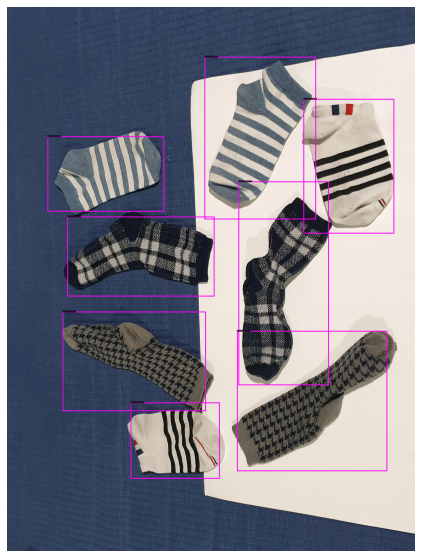

/gdrive/MyDrive/CS470_Socks_Sorting


In [ ]:
# Single image
%cd $ROOT_DIR
%cd darknet
os.system("./darknet detector test data/Sock.data cfg/yolov4-tiny-custom.cfg backup/yolov4-tiny-custom_best.weights ../ckhr3w0s4000g3g698wf538ho_aug6.jpg -ext_output -dont_show -out esult.json")
imShow('predictions.jpg')
%cd $ROOT_DIR

/gdrive/My Drive/CS470_Socks_Sorting/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/la

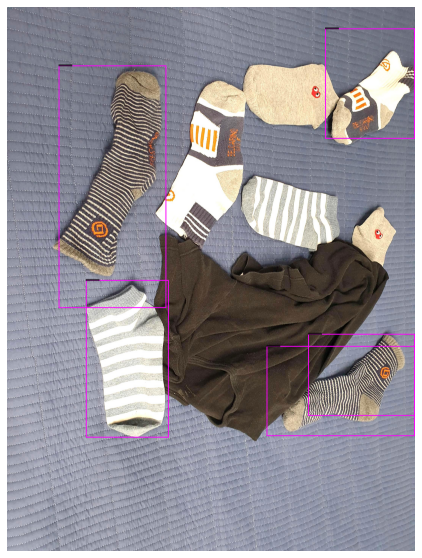

/gdrive/MyDrive/CS470_Socks_Sorting


In [ ]:
# Single image
%cd darknet
!./darknet detector test data/Sock.data cfg/yolov4-tiny-custom.cfg backup/yolov4-tiny-1cls_best.weights ../example_sock.jpg -ext_output -dont_show -out r11esult.json 
imShow('predictions.jpg')
%cd $ROOT_DIR

In [ ]:
# Several images
# < ./data/test.txt > 자리에 이미지 이름 들어간 텍스트 파일 넣으면 됨
!./darknet detector test data/Sock.data cfg/yolov4-tiny-custom.cfg backup/yolov4-tiny-custom_best.weights -dont_show -ext_output < ./data/test.txt > Sock1result.txt

/gdrive/MyDrive/CS470_Socks_Sorting
/gdrive/MyDrive/CS470_Socks_Sorting/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Canno

In [ ]:
!./darknet detector map data/Sock.data cfg/yolov4-tiny-custom.cfg backup/yolov4-tiny-custom_best.weights

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104

# 5. Training EfficientNet on Custom dataset

In [ ]:
%cd {ROOT_DIR}EfficientNet-PyTorch
from efficientnet_pytorch import EfficientNet

/gdrive/MyDrive/CS470_Socks_Sorting/EfficientNet-PyTorch


### Prepare Images

In [ ]:
images_dir = "../SockClasses"

### Load Model

In [ ]:
model_name = 'efficientnet-b0' 

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=10)

224


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
# freeze every layer before fc
for n, p in model.named_parameters():
    if '_fc' not in n:
        p.requires_grad = False

### Dataset and Dataloader

In [ ]:
random_seed = 300
random.seed(random_seed)
torch.manual_seed(random_seed)

from torchvision import datasets
sock_dataset = datasets.ImageFolder(images_dir,
                                    T.Compose([T.ColorJitter(brightness=.2, contrast=.2, saturation=.1, hue=.05),
                                               T.RandomResizedCrop((224,224)),
                                               T.RandomHorizontalFlip(p=0.5),
                                               T.ToTensor(),
                                               T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                               T.RandomErasing(value="random")]))
print(len(sock_dataset))

951


In [ ]:
batch_size  = 64
num_workers = 12
random_seed = 300
random.seed(random_seed)
torch.manual_seed(random_seed)

## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
train_idx, tmp_idx = train_test_split(list(range(len(sock_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(sock_dataset, train_idx)
tmp_dataset       = Subset(sock_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loaders
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(datasets['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers)
dataloaders['valid'] = DataLoader(datasets['valid'],
                                  batch_size=batch_size, shuffle=False,
                                  num_workers=num_workers)
dataloaders['test']  = DataLoader(datasets['test'],
                                  batch_size=batch_size, shuffle=False,
                                  num_workers=num_workers)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  tvt : 12 / 2 / 2


In [ ]:
def imshow(input_tensor, title=None):
    """Imshow for Tensor."""
    input_np = input_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_np = std * input_np + mean
    input_np = np.clip(input_np, 0, 1)
    plt.imshow(input_np)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

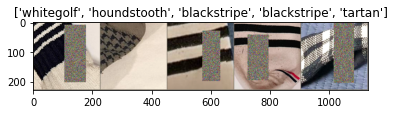

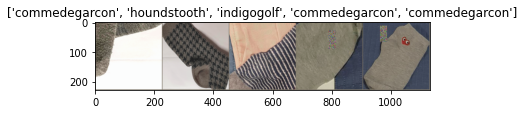

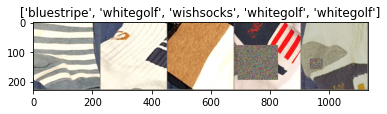

In [ ]:
# 시간 은근히 걸림. 한 5분?

num_show_img = 5

class_names = {
    '0': 'houndstooth',
    '1': 'beigethombrowne',
    '2': 'bluestripe',
    '3': 'wishsocks',
    '4': 'commedegarcon',
    '5': 'indigogolf',
    '6': 'whitegolf',
    '7': 'blackstripe',
    '8': 'moomin',
    '9': 'tartan'
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img]) 
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

### Training function

In [ ]:
log_dir = "logs/"
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

def train_model(model, criterion, optimizer, scheduler, train_dataloader, valid_dataloader, num_epochs=25, log_dir=log_dir):
    trial = 0
    while os.path.exists(log_dir + f"trial{trial}/"):
      trial += 1
    save_dir = log_dir + f"trial{trial}/"
    os.mkdir(save_dir)

    print_every = 10
    dataloaders = {'train': train_dataloader, 'valid': valid_dataloader}

    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    t = time.time()
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, axis=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt) #
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.3g} Acc: {epoch_acc:.3g}')

            if phase == 'valid':
                torch.save(model.state_dict(), save_dir + f'sock_clsfy_last.pt')
                print(f'==> model saved - {epoch} / acc {epoch_acc:.3g} %%')
                if epoch_acc > best_acc:
                    best_epoch = epoch
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), save_dir + f'sock_clsfy_best.pt')
                    print(f'==> best model saved - {best_epoch} / acc {best_acc:.3g} %%')

        print('-' * 10)

    time_elapsed = time.time() - t
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_epoch} epoch, {best_acc :.4f}%')

    return model, best_epoch, best_acc, train_loss, train_acc, valid_loss, valid_acc


### Testing Function

In [ ]:
def test_and_visualize_model(model, test_dataloader, num_images=10, visualize=True):
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            prob, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if i == 0 and visualize :
                for j in range(1, num_images+1):
                    ax = plt.subplot(num_images//2, 2, j)
                    ax.axis('off')
                    ax.set_title('%s : %s -> %s'%(
                        'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                        class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                    imshow(inputs.cpu().data[j])          

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size
            

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

        model.train(mode=was_training);

In [ ]:
def infer_image_with_EN(model, image):
    """
    model: EfficentNet Model.
    image: PIL image.
    """  
    was_training = model.training
    model.eval()
    
    num_cnt = 0
    transform_img = T.Compose([T.Resize((224, 224)),
                               T.ToTensor(),
                               T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    inputimg = transform_img(image).unsqueeze(0)

    with torch.no_grad():
        inputs = inputimg.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, axis=1)
        inference = class_names_list[int(preds.view(-1).cpu())]

        #print(f'test done - inference : {inference}')

    model.train(mode=was_training);
    return inputimg, inference

### Training

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), 
                      lr = 0.05,
                      momentum=0.9,
                      weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
 

In [ ]:
random_seed = 3
random.seed(random_seed)
torch.manual_seed(random_seed)
model, best_epoch, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders['train'], dataloaders['valid'], num_epochs=50)

### Testing example

In [ ]:
# Load weight
weight_path = "./logs/trial0/sock_clsfy_best.pt"
trained_model = EfficientNet.from_name('efficientnet-b0', num_classes=10)
trained_model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

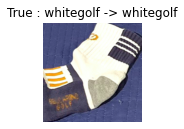

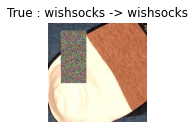

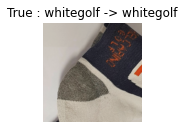

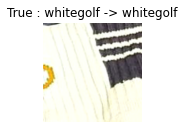

test done : loss/acc : 0.20 / 92.7


In [ ]:
trained_model = trained_model.to(device)
test_and_visualize_model(trained_model, dataloaders['test'], num_images=4, visualize=True)

# ALL TOGETHER: Inference of an image with Sock & Clothing

In [ ]:
print("""
Please run the following Cells:

(Starting cells) Model Training ~~
Load Model ~~
Training EfficientNet on Custom datasett - Testing Function
""")


Please run the following Cells:

(Starting cells) Model Training ~~
Load Model ~~
Training EfficientNet on Custom datasett - Testing Function



In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" 
transform_img = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

/gdrive/MyDrive/CS470_Socks_Sorting
/gdrive/MyDrive/CS470_Socks_Sorting/upload_img


Saving ckhr3w0s4000g3g698wf538ho_aug7.jpg to ckhr3w0s4000g3g698wf538ho_aug7.jpg
saved file ckhr3w0s4000g3g698wf538ho_aug7.jpg
/gdrive/My Drive/CS470_Socks_Sorting
Input Image Path: /gdrive/MyDrive/CS470_Socks_Sorting/upload_img/ckhr3w0s4000g3g698wf538ho_aug7.jpg


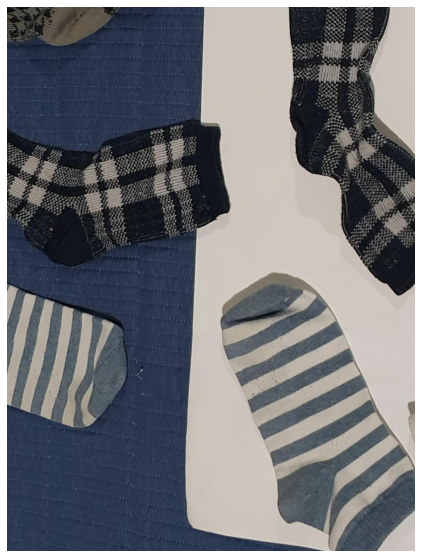

In [ ]:
# UPLOAD IMAGE
from PIL import Image
%cd $ROOT_DIR
upload_dir = "upload_img/"
%cd $upload_dir
imgname = upload()[0]
%cd ..
image_path = ROOT_DIR + upload_dir + imgname
print("Input Image Path:", image_path)
imShow(image_path)
img = Image.open(image_path)
width, height = img.size

In [ ]:
# LOAD MODELS
yolo_data = "data/Sock.data"
yolo_cfg = "cfg/yolov4-tiny-custom.cfg"
yolo_weights = "backup/yolov4-tiny-custom_best.weights"
yolo_result_json = "prediction.json"

%cd $ROOT_DIR/EfficientNet-PyTorch
from efficientnet_pytorch import EfficientNet
%cd $ROOT_DIR
en_weight_path = ROOT_DIR + "EfficientNet-PyTorch/logs/trial0/sock_clsfy_best.pt"
cls_classes = 10
en_model = EfficientNet.from_name('efficientnet-b0', num_classes=cls_classes)
en_model.load_state_dict(torch.load(en_weight_path))
en_model.to(device)



/gdrive/MyDrive/CS470_Socks_Sorting/EfficientNet-PyTorch
/gdrive/MyDrive/CS470_Socks_Sorting


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

/gdrive/MyDrive/CS470_Socks_Sorting
/gdrive/MyDrive/CS470_Socks_Sorting/darknet
Detected Socks By Yolo:


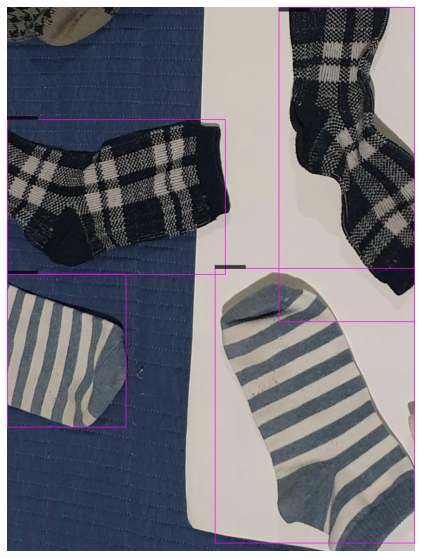

In [ ]:
# YOLO Detection
%cd $ROOT_DIR
%cd darknet
import subprocess
import shlex
text = f"./darknet detector test {yolo_data} {yolo_cfg} {yolo_weights} {image_path} -ext_output -dont_show -out {yolo_result_json}"
process = subprocess.Popen(shlex.split(text),
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
stdout, _ = process.communicate()
print("Detected Socks By Yolo:")
imShow("predictions.jpg")
import json
with open(yolo_result_json, "r") as f:
    yolo_inference_data = json.load(f)
bboxes = yolo_inference_data[0]['objects']

/gdrive/My Drive/CS470_Socks_Sorting/EfficientNet-PyTorch


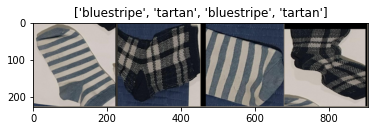

In [ ]:
# EfficientNet Classification
%cd ../EfficientNet-PyTorch

class_names = {
    '0': 'houndstooth',
    '1': 'beigethombrowne',
    '2': 'bluestripe',
    '3': 'wishsocks',
    '4': 'commedegarcon',
    '5': 'indigogolf',
    '6': 'whitegolf',
    '7': 'blackstripe',
    '8': 'moomin',
    '9': 'tartan'
}
class_names_list = list(class_names.values())

socks, names = [], []
for obj in bboxes:
    bbox = obj["relative_coordinates"]
    xmid, ymid, w, h = bbox["center_x"], bbox["center_y"], bbox["width"], bbox["height"]
    xmin, xmax = round((xmid - w/2) * width), round((xmid + w/2) * width)
    ymin, ymax = round((ymid - h/2) * height), round((ymid + h/2) * height)
    cropped_img = img.crop((xmin, ymin, xmax, ymax))

    imm, prediction = infer_image_with_EN(en_model,cropped_img)
    imm=imm.squeeze()
        
    socks.append(imm)
    names.append(prediction)
out = torchvision.utils.make_grid(socks)  
imshow(out, title=names)

In [ ]:
# Count Socks

from collections import Counter
count = dict(Counter(names))
paired, unpaired, overdetected = [], [], []
for k, v in count.items():
    if v == 2:
        paired.append(k)
    elif v == 1:
        unpaired.append(k)
    else: # v>3
        overdetected.append(k)
undetected = list(set(class_names_list.copy()) - set(paired + unpaired + overdetected))

count_result = f"""
Paired Socks      : {paired}
Unpaired Socks    : {unpaired}
Overdetected Socks: {overdetected}
Undetected Socks  : {undetected}
"""
print(count_result)
if unpaired + overdetected == [] and len(paired + undetected) == cls_classes:
    print("All paired!")
else:
    print("Go and find missing socks: \n", unpaired)


Paired Socks      : ['bluestripe', 'tartan']
Unpaired Socks    : []
Overdetected Socks: []
Undetected Socks  : ['blackstripe', 'indigogolf', 'commedegarcon', 'wishsocks', 'beigethombrowne', 'moomin', 'whitegolf', 'houndstooth']

All paired!
